In [1]:
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
from torchvision.utils import save_image
import matplotlib.pyplot as plt

SyntaxError: ignored

In [2]:
class AE(nn.Module):
  def __init__(self):
    super(AE, self).__init__()
    self.encoder = Encoder(10,128)
    self.decoder = Decoder(10,128)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

ModuleNotFoundError: ignored

In [ ]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__() 
        self.num_for_interp = 0       
        self.interp_list = []
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(3 * 3 * 32, 128)
        self.fc2 = nn.Linear(128, encoded_space_dim)
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        if self.num_for_interp < 2:
            self.interp_list.append(x)
        return x

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.fc1 = nn.Linear(encoded_space_dim, 128)
        self.fc2 = nn.Linear(128, 3 * 3 * 32)    

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        self.conv1t = nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2t = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.conv3t = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.unflatten(x)
        x = F.relu(self.bn1(self.conv1t(x)))
        x = F.relu(self.bn2(self.conv2t(x)))
        x = torch.sigmoid(self.conv3t(x))
        return x

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [ ]:
def train(model, device, dataloader, loss_mse, optimizer):
    model.train()
    train_loss = []
    for image, i in dataloader:
        image = image.to(device)
        encoded_data = model(image)
        loss = loss_mse(encoded_data, image)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
DATA_PATH = '../data_sets/mnist'

train_set = datasets.MNIST(root=DATA_PATH, train=True, download=True, transform=transform)
test_set = datasets.MNIST(root=DATA_PATH, train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True)

In [ ]:
loss_mse = torch.nn.MSELoss()
ae = AE()

In [ ]:
learning_rate = 0.001
device = get_device()
ae.to(device)
optimizer = optim.Adam(ae.parameters(), lr=learning_rate)

In [ ]:
def test(ae, device, dataloader, loss_fn):
    ae.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, i in dataloader:
            image = image_batch.to(device)
            decoded_data = ae(image)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
def plot_ae_outputs(ae, n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_set.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_set[t_idx[i]][0].unsqueeze(0).to(device)
      ae.eval()
      with torch.no_grad():
         rec_img  = ae(img)
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 1.981200
	 partial train loss (single batch): 1.969204
	 partial train loss (single batch): 1.940914
	 partial train loss (single batch): 1.937056
	 partial train loss (single batch): 1.925220
	 partial train loss (single batch): 1.923598
	 partial train loss (single batch): 1.909585
	 partial train loss (single batch): 1.879881
	 partial train loss (single batch): 1.891541
	 partial train loss (single batch): 1.882214
	 partial train loss (single batch): 1.881731
	 partial train loss (single batch): 1.864968
	 partial train loss (single batch): 1.858010
	 partial train loss (single batch): 1.859652
	 partial train loss (single batch): 1.846700
	 partial train loss (single batch): 1.860891
	 partial train loss (single batch): 1.812493
	 partial train loss (single batch): 1.829813
	 partial train loss (single batch): 1.818609
	 partial train loss (single batch): 1.807921
	 partial train loss (single batch): 1.811466
	 partial train loss (single batch

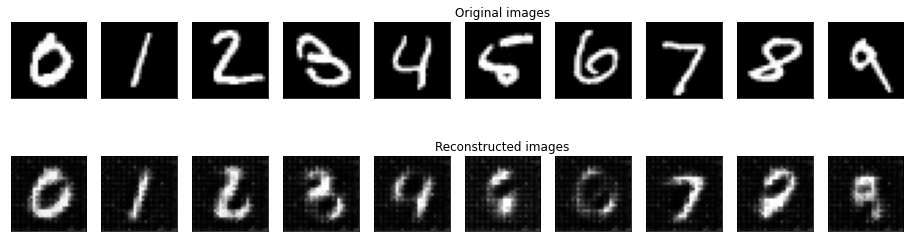

	 partial train loss (single batch): 0.934259
	 partial train loss (single batch): 0.934803
	 partial train loss (single batch): 0.932964
	 partial train loss (single batch): 0.931282
	 partial train loss (single batch): 0.927768
	 partial train loss (single batch): 0.931478
	 partial train loss (single batch): 0.933773
	 partial train loss (single batch): 0.936503
	 partial train loss (single batch): 0.933624
	 partial train loss (single batch): 0.928801
	 partial train loss (single batch): 0.927939
	 partial train loss (single batch): 0.926345
	 partial train loss (single batch): 0.925892
	 partial train loss (single batch): 0.930506
	 partial train loss (single batch): 0.927502
	 partial train loss (single batch): 0.926547
	 partial train loss (single batch): 0.926494
	 partial train loss (single batch): 0.935428
	 partial train loss (single batch): 0.927377
	 partial train loss (single batch): 0.926581
	 partial train loss (single batch): 0.930530
	 partial train loss (single batch

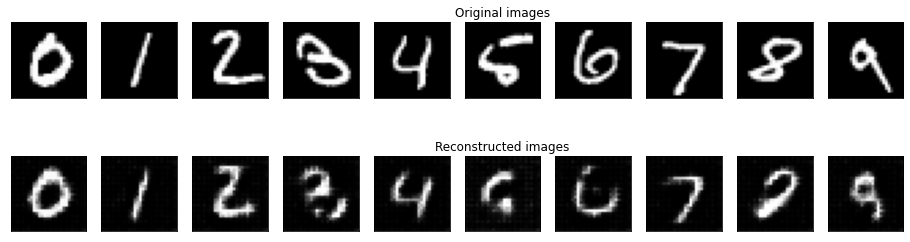

	 partial train loss (single batch): 0.898017
	 partial train loss (single batch): 0.891931
	 partial train loss (single batch): 0.900048
	 partial train loss (single batch): 0.902433
	 partial train loss (single batch): 0.893200
	 partial train loss (single batch): 0.900027
	 partial train loss (single batch): 0.898481
	 partial train loss (single batch): 0.898882
	 partial train loss (single batch): 0.894427
	 partial train loss (single batch): 0.900151
	 partial train loss (single batch): 0.899954
	 partial train loss (single batch): 0.899177
	 partial train loss (single batch): 0.894483
	 partial train loss (single batch): 0.899835
	 partial train loss (single batch): 0.895621
	 partial train loss (single batch): 0.895228
	 partial train loss (single batch): 0.898041
	 partial train loss (single batch): 0.900533
	 partial train loss (single batch): 0.899348
	 partial train loss (single batch): 0.894682
	 partial train loss (single batch): 0.890992
	 partial train loss (single batch

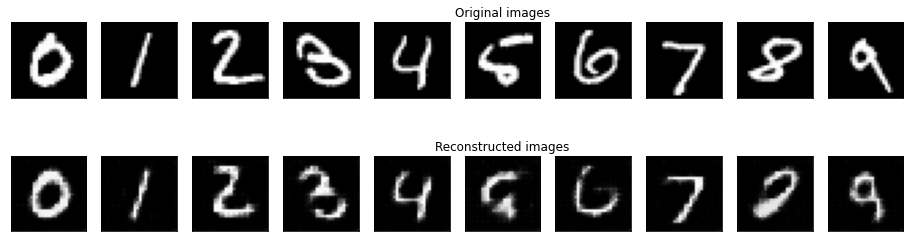

	 partial train loss (single batch): 0.886352
	 partial train loss (single batch): 0.886955
	 partial train loss (single batch): 0.890431
	 partial train loss (single batch): 0.883521
	 partial train loss (single batch): 0.889812
	 partial train loss (single batch): 0.890266
	 partial train loss (single batch): 0.887483
	 partial train loss (single batch): 0.889560
	 partial train loss (single batch): 0.892794
	 partial train loss (single batch): 0.891602
	 partial train loss (single batch): 0.892762
	 partial train loss (single batch): 0.894118
	 partial train loss (single batch): 0.892653
	 partial train loss (single batch): 0.887877
	 partial train loss (single batch): 0.886576
	 partial train loss (single batch): 0.882433
	 partial train loss (single batch): 0.884625
	 partial train loss (single batch): 0.888590
	 partial train loss (single batch): 0.887395
	 partial train loss (single batch): 0.887993
	 partial train loss (single batch): 0.892202
	 partial train loss (single batch

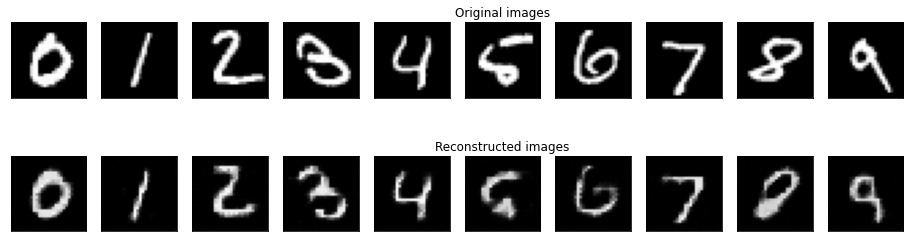

	 partial train loss (single batch): 0.882002
	 partial train loss (single batch): 0.886774
	 partial train loss (single batch): 0.889262
	 partial train loss (single batch): 0.885565
	 partial train loss (single batch): 0.884673
	 partial train loss (single batch): 0.881450
	 partial train loss (single batch): 0.882227
	 partial train loss (single batch): 0.889882
	 partial train loss (single batch): 0.881631
	 partial train loss (single batch): 0.884221
	 partial train loss (single batch): 0.883684
	 partial train loss (single batch): 0.885819
	 partial train loss (single batch): 0.883688
	 partial train loss (single batch): 0.887317
	 partial train loss (single batch): 0.884483
	 partial train loss (single batch): 0.881533
	 partial train loss (single batch): 0.881080
	 partial train loss (single batch): 0.881547
	 partial train loss (single batch): 0.885279
	 partial train loss (single batch): 0.882944
	 partial train loss (single batch): 0.883671
	 partial train loss (single batch

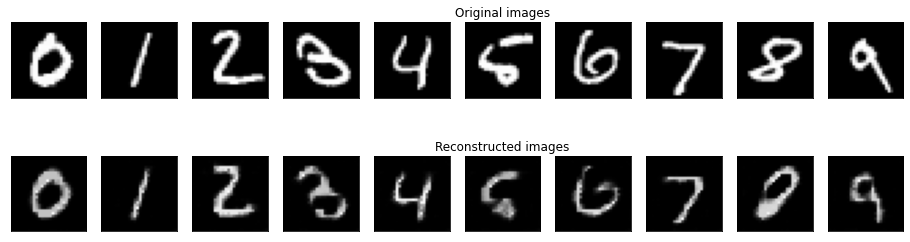

	 partial train loss (single batch): 0.881749
	 partial train loss (single batch): 0.881479
	 partial train loss (single batch): 0.877685
	 partial train loss (single batch): 0.880915
	 partial train loss (single batch): 0.880379
	 partial train loss (single batch): 0.882322
	 partial train loss (single batch): 0.887893
	 partial train loss (single batch): 0.879166
	 partial train loss (single batch): 0.882014
	 partial train loss (single batch): 0.880822
	 partial train loss (single batch): 0.883991
	 partial train loss (single batch): 0.885403
	 partial train loss (single batch): 0.883546
	 partial train loss (single batch): 0.884309
	 partial train loss (single batch): 0.884480
	 partial train loss (single batch): 0.874265
	 partial train loss (single batch): 0.882046
	 partial train loss (single batch): 0.880093
	 partial train loss (single batch): 0.878998
	 partial train loss (single batch): 0.878812
	 partial train loss (single batch): 0.881828
	 partial train loss (single batch

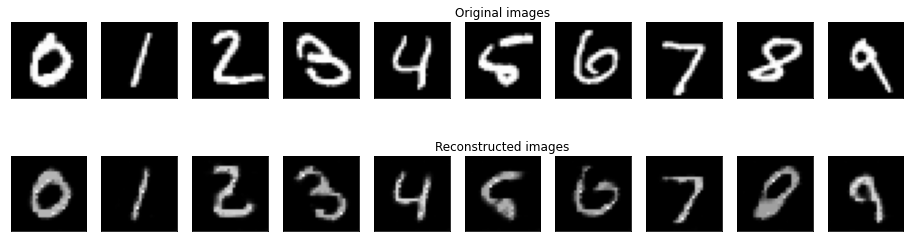

	 partial train loss (single batch): 0.880046
	 partial train loss (single batch): 0.876599
	 partial train loss (single batch): 0.879758
	 partial train loss (single batch): 0.879236
	 partial train loss (single batch): 0.882946
	 partial train loss (single batch): 0.884124
	 partial train loss (single batch): 0.875490
	 partial train loss (single batch): 0.875153
	 partial train loss (single batch): 0.880996
	 partial train loss (single batch): 0.873253
	 partial train loss (single batch): 0.880188
	 partial train loss (single batch): 0.878259
	 partial train loss (single batch): 0.882987
	 partial train loss (single batch): 0.877494
	 partial train loss (single batch): 0.874327
	 partial train loss (single batch): 0.874220
	 partial train loss (single batch): 0.886902
	 partial train loss (single batch): 0.879946
	 partial train loss (single batch): 0.877831
	 partial train loss (single batch): 0.878645
	 partial train loss (single batch): 0.881764
	 partial train loss (single batch

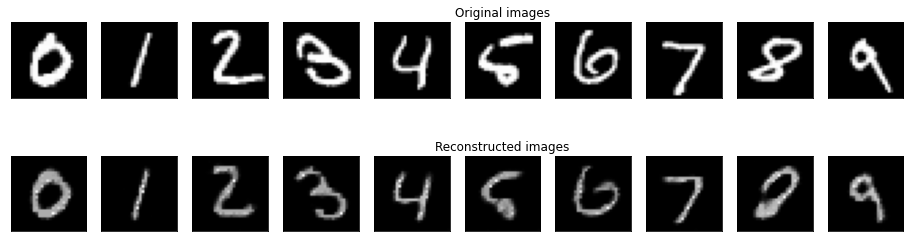

	 partial train loss (single batch): 0.880669
	 partial train loss (single batch): 0.875026
	 partial train loss (single batch): 0.873384
	 partial train loss (single batch): 0.874396
	 partial train loss (single batch): 0.880802
	 partial train loss (single batch): 0.875558
	 partial train loss (single batch): 0.877557
	 partial train loss (single batch): 0.873541
	 partial train loss (single batch): 0.884719
	 partial train loss (single batch): 0.872542
	 partial train loss (single batch): 0.879349
	 partial train loss (single batch): 0.875270
	 partial train loss (single batch): 0.876244
	 partial train loss (single batch): 0.872535
	 partial train loss (single batch): 0.874653
	 partial train loss (single batch): 0.882755
	 partial train loss (single batch): 0.874217
	 partial train loss (single batch): 0.876044
	 partial train loss (single batch): 0.881889
	 partial train loss (single batch): 0.881145
	 partial train loss (single batch): 0.879673
	 partial train loss (single batch

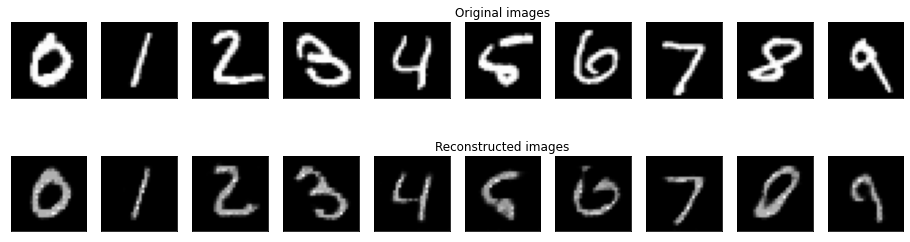

	 partial train loss (single batch): 0.871269
	 partial train loss (single batch): 0.869858
	 partial train loss (single batch): 0.876621
	 partial train loss (single batch): 0.873117
	 partial train loss (single batch): 0.871804
	 partial train loss (single batch): 0.873839
	 partial train loss (single batch): 0.872352
	 partial train loss (single batch): 0.874221
	 partial train loss (single batch): 0.873580
	 partial train loss (single batch): 0.877634
	 partial train loss (single batch): 0.875786
	 partial train loss (single batch): 0.876848
	 partial train loss (single batch): 0.872289
	 partial train loss (single batch): 0.866771
	 partial train loss (single batch): 0.868773
	 partial train loss (single batch): 0.871868
	 partial train loss (single batch): 0.871318
	 partial train loss (single batch): 0.873498
	 partial train loss (single batch): 0.877224
	 partial train loss (single batch): 0.873429
	 partial train loss (single batch): 0.875837
	 partial train loss (single batch

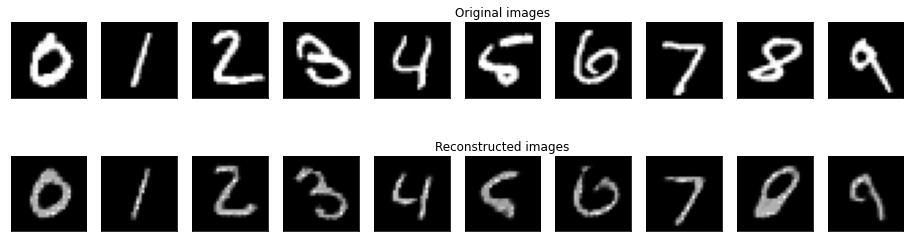

	 partial train loss (single batch): 0.876113
	 partial train loss (single batch): 0.874363
	 partial train loss (single batch): 0.870399
	 partial train loss (single batch): 0.869416
	 partial train loss (single batch): 0.870592
	 partial train loss (single batch): 0.870695
	 partial train loss (single batch): 0.870193
	 partial train loss (single batch): 0.874545
	 partial train loss (single batch): 0.870511
	 partial train loss (single batch): 0.866398
	 partial train loss (single batch): 0.870694
	 partial train loss (single batch): 0.867386
	 partial train loss (single batch): 0.872245
	 partial train loss (single batch): 0.870959
	 partial train loss (single batch): 0.871240
	 partial train loss (single batch): 0.871531
	 partial train loss (single batch): 0.869031
	 partial train loss (single batch): 0.870472
	 partial train loss (single batch): 0.866198
	 partial train loss (single batch): 0.868085
	 partial train loss (single batch): 0.871322
	 partial train loss (single batch

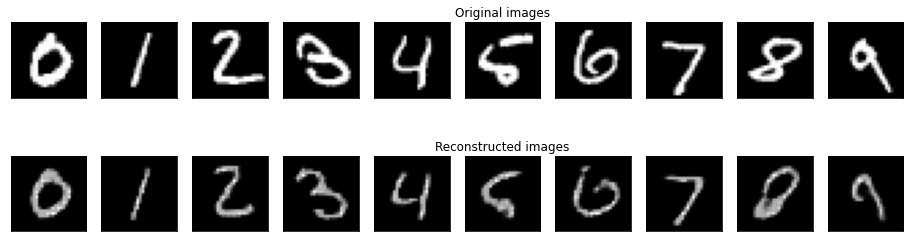

In [ ]:
num_epochs = 10
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss = train(ae, device, train_loader, loss_mse, optimizer)
   val_loss = test(ae,device,test_loader,loss_mse)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(ae,n=10)

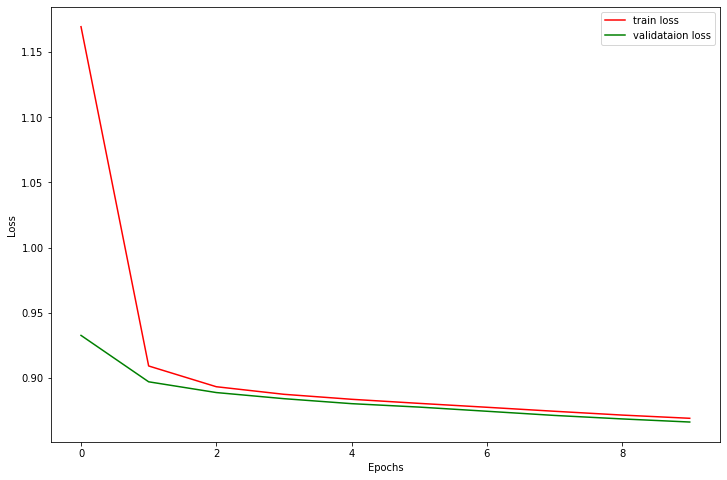

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(diz_loss['train_loss'], color='red', label='train loss')
plt.plot(diz_loss['val_loss'], color='green', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
alpha = 0.1
z_0 = ae.encoder.interp_list[0]
z_1 = ae.encoder.interp_list[1]
mids = [z_0]
while alpha < 1:
    mid_z = alpha * z_0 + (1 - alpha)*z_1
    mids.append(mid_z)
    alpha *= 2
mids.append(z_1)

In [ ]:
i = 0
for z in mids:
    i += 1
    rec = ae.decoder(z)
    save_image(rec.cpu(), f"intrp{i}.jpg")

In [ ]:
test_image= ae.encoder.interp_list[0]

plt.imshow(test_image.reshape(28, 28))
plt.show()
# encoded_img=encoder.predict(test_image)
# plt.imshow(encoded_img)
# plt.show()
# decoded_img=decoder.predict(encoded_img)
# plt.imshow(decoded_img.reshape(28,28))
# plt.show()
# decoded_img2=autoencoder.predict(test_image)
# plt.imshow(decoded_img2.reshape(28,28))
# plt.show()

RuntimeError: ignored

In [ ]:
def plot_ae_outputs(ae, n=1):
    plt.figure(figsize=(16,4.5))
    targets = test_set.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_set[t_idx[i]][0].unsqueeze(0).to(device)
      ae.eval()
      with torch.no_grad():
         rec_img  = ae(img)
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

In [ ]:
d = torch.load(path + "\\ex3\\Decoder10.pth")
e = torch.load(path + "\\ex3\\Encoder10.pth")
loader = DataLoader.get_loader(2, train=False)
sample = next(iter(loader))[0]
L_1, L_2 = sample[0][:, None], sample[1][:, None]
alphas = np.linspace(0, 1, 16)
images = [(d(e(L_1 * a + (1 - a) * L_2)).detach().numpy(), a) for a in alphas]
show_images(images)